In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from itertools import combinations
from typing import List, Tuple

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

from mlxtend.plotting import plot_decision_regions

from statsmodels.formula.api import glm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

In [100]:
def backward_elimination(features: List[str], target: str, train_df: pd.DataFrame) -> GLM:
    """
    Perform backward elimination to select the best subset of features based on lowest AIC.

    Parameters:
    -----------
    features : List[str]
        List of initial feature names to evaluate.
    target : str
        Name of the target variable.
    train_df : pd.DataFrame
        DataFrame containing both the features and the target.

    Returns:
    --------
    Tuple[GLM, Tuple[str, ...]]
        A tuple containing:
        - The fitted GLM model with the best feature combination.
        - The tuple of feature names used in the best model.
    """
    current_features = features.copy()
    lowest_aic = float('inf')
    best_features = []

    while len(current_features) > 0:
        formula = f'{target} ~ ' + ' + '.join(current_features)
        model = glm(formula=formula, data=train_df).fit()

        print(f'Evaluating: {", ".join(current_features)}, AIC = {model.aic:.2f} (backward_elimination)')

        if model.aic < lowest_aic:
            lowest_aic = model.aic
            best_features = current_features.copy()

        current_features.pop()

    final_formula = f'{target} ~ ' + ' + '.join(best_features)
    final_model = glm(formula=final_formula, data=train_df).fit()

    return final_model, best_features

def exhaustive_search(features: List[str], target: str, train_df: pd.DataFrame) -> Tuple[GLM, Tuple[str, ...]]:
    """
    Performs an exhaustive search over all possible non-empty combinations of the provided features,
    selecting the combination that results in the lowest AIC when used in a GLM.

    Parameters:
    -----------
    features : List[str]
        List of feature names to consider.
    target : str
        Name of the target variable.
    train_df : pd.DataFrame
        The DataFrame containing the features and target variable.

    Returns:
    --------
    Tuple[GLM, Tuple[str, ...]]
        A tuple containing:
        - The fitted GLM model with the best feature combination.
        - The tuple of feature names used in the best model.
    """
    best_aic = float('inf')
    best_features = ()

    for r in range(1, len(features) + 1):
        for combo in combinations(features, r):
            formula = f"{target} ~ {' + '.join(combo)}"
            model = glm(formula=formula, data=train_df).fit()

            print(f"Evaluating: {combo}, AIC = {model.aic:.2f} (exhaustive_search)")

            if model.aic < best_aic:
                best_aic = model.aic
                best_features = combo

    best_formula = f"{target} ~ {' + '.join(best_features)}"
    final_model = glm(formula=best_formula, data=train_df).fit()

    return final_model, best_features

def stepwise_forward_selection(features: List[str], target: str, train_df: pd.DataFrame) -> Tuple[GLM, List[str]]:
    """
    Performs stepwise forward selection to iteratively add features that reduce AIC the most.
    Starts from an empty model and adds one feature at a time, selecting the one that yields
    the greatest improvement in AIC until no further improvement is possible.

    Parameters:
    -----------
    features : List[str]
        List of all candidate feature names.
    target : str
        Name of the target variable.
    train_df : pd.DataFrame
        DataFrame containing both the features and the target.

    Returns:
    --------
    Tuple[GLM, List[str]]
        A tuple containing:
        - The fitted GLM model with the best subset of features.
        - The list of selected feature names.
    """
    remaining = features.copy()
    selected = []

    best_aic = float('inf')
    best_model = None
    best_features = []

    for feature in remaining:
        trial = selected + [feature]

        formula = f"{target} ~ {' + '.join(trial)}"
        model = glm(formula=formula, data=train_df).fit()

        print(f"Evaluating: {trial}, AIC = {model.aic:.2f} (forward_stepwise)")

        if model.aic < best_aic:
            best_aic = model.aic
            best_model = model
            best_features = selected.copy()

        selected.append(feature)

    return best_model, best_features

In [101]:
heart = pd.read_csv('..\\data\\heart.csv').dropna()
heart.head()

,age,trestbps,chol,thalach,target
0,59,170,326,140,0
1,63,140,187,144,0
2,44,110,197,177,0
3,39,94,199,179,1
4,63,140,187,144,0


In [102]:
scaler = StandardScaler()

X = heart[['age', 'trestbps', 'chol', 'thalach']]
y = heart[['target']]

X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled

,age,trestbps,chol,thalach
0,0.624677,2.479928,1.677410,-0.477045
1,1.058481,0.628314,-1.338110,-0.281535
2,-1.002087,-1.223299,-1.121166,1.331425
3,-1.544341,-2.210826,-1.077777,1.429180
4,1.058481,0.628314,-1.338110,-0.281535
5,1.383834,0.998637,0.636079,0.109486
6,-1.435890,1.368960,-0.557112,1.526935
7,-0.026028,0.751755,-0.492029,-1.894494
8,-0.893636,-1.593622,-0.882528,-0.086025
9,-1.327440,0.319712,-0.991000,-0.868065


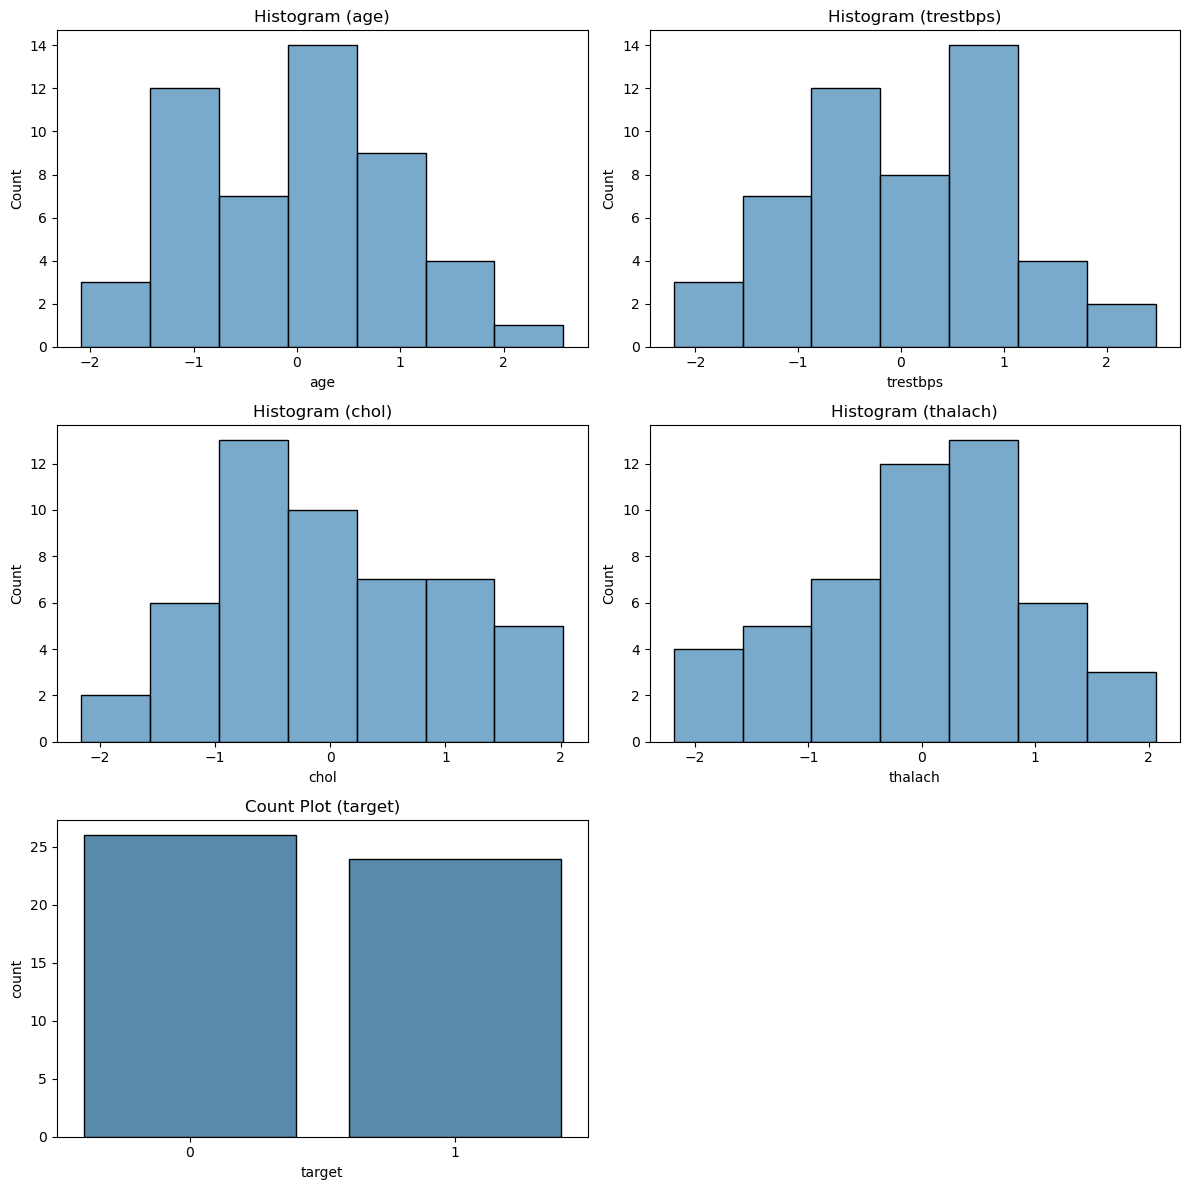

In [119]:
df_copy = X_scaled.copy(deep=False)
df_copy['target'] = y

train_df, test_df = train_test_split(df_copy, test_size=0.1, random_state=42)

train_X = train_df
train_y = train_df[target]

test_X = test_df
test_y = test_df[target]

features = [col for col in train_df.columns if col != 'target']
target = 'target'
all_cols = features + [target]

cols_per_row = 2

num_plots = len(all_cols)
num_rows = int(np.ceil(num_plots / cols_per_row))

fig, axes = plt.subplots(num_rows, cols_per_row, figsize=(6 * cols_per_row, 4 * num_rows))
axes = axes.flatten()

for index, col in enumerate(all_cols):
    ax = axes[index]

    if train_df[col].nunique(dropna=True) <= 10:
        sns.countplot(data=df_copy, x=col, ax=ax, color="#4c8cba", edgecolor="black")
        ax.set_title(f"Count Plot ({col})")
    else:
        sns.histplot(data=df_copy, x=col, ax=ax, color="#4c8cba")
        ax.set_title(f"Histogram ({col})")

for i in range(len(all_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [120]:
formula = f"{target} ~ {' + '.join(features)}"

model_unoptimized = glm(formula=formula, data=train_df).fit()
model_unoptimized.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                   45
Model:                            GLM   Df Residuals:                       40
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                         0.24347
Method:                          IRLS   Log-Likelihood:                -29.415
Date:                Fri, 01 Aug 2025   Deviance:                       9.7388
Time:                        18:23:17   Pearson chi2:                     9.74
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1307
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4712      0.074      6.384      0.000       0.327       0.616
age           -0.0592      0.081     -0.728      0.466      -0.219       0.100
trestbps      -0.0915      0.078     -1.181      0.238      -0.243       0.060
chol          -0.0223      0.073     -0.305      0.760      -0.166       0.121
thalach        0.1140      0.081      1.405      0.160      -0.045       0.273
==============================================================================
"""

In [121]:
current_features = features.copy()

backward_model, backward_features = backward_elimination(features, target, train_df)
exhaustive_model, exhaustive_features = exhaustive_search(features, target, train_df)
forward_model, forward_features = stepwise_forward_selection(features, target, train_df)

Evaluating: age, trestbps, chol, thalach, AIC = 68.83 (backward_elimination)
Evaluating: age, trestbps, chol, AIC = 69.00 (backward_elimination)
Evaluating: age, trestbps, AIC = 67.08 (backward_elimination)
Evaluating: age, AIC = 66.61 (backward_elimination)
Evaluating: ('age',), AIC = 66.61 (exhaustive_search)
Evaluating: ('trestbps',), AIC = 66.89 (exhaustive_search)
Evaluating: ('chol',), AIC = 68.60 (exhaustive_search)
Evaluating: ('thalach',), AIC = 65.74 (exhaustive_search)
Evaluating: ('age', 'trestbps'), AIC = 67.08 (exhaustive_search)
Evaluating: ('age', 'chol'), AIC = 68.45 (exhaustive_search)
Evaluating: ('age', 'thalach'), AIC = 66.56 (exhaustive_search)
Evaluating: ('trestbps', 'chol'), AIC = 68.59 (exhaustive_search)
Evaluating: ('trestbps', 'thalach'), AIC = 65.65 (exhaustive_search)
Evaluating: ('chol', 'thalach'), AIC = 67.32 (exhaustive_search)
Evaluating: ('age', 'trestbps', 'chol'), AIC = 69.00 (exhaustive_search)
Evaluating: ('age', 'trestbps', 'thalach'), AIC = 66

In [122]:
best_aic = float('inf')
best_model = None

search_types = ['exhaustive', 'forward', 'backward']
search_models = [exhaustive_model, forward_model, backward_model]

for search_type, search_model in zip(search_types, search_models):
    if search_model.aic < best_aic:
        print(f'Search type {search_type}, AIC = {search_model.aic}')
        best_aic = search_model.aic
        best_model = search_model

best_model.summary()

Search type exhaustive, AIC = 65.65244979291236


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 target   No. Observations:                   45
Model:                            GLM   Df Residuals:                       42
Model Family:                Gaussian   Df Model:                            2
Link Function:               Identity   Scale:                         0.23615
Method:                          IRLS   Log-Likelihood:                -29.826
Date:                Fri, 01 Aug 2025   Deviance:                       9.9184
Time:                        18:23:19   Pearson chi2:                     9.92
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1157
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4704      0.073      6.471      0.000       0.328       0.613
trestbps      -0.1055      0.075     -1.414      0.157      -0.252       0.041
thalach        0.1341      0.076      1.769      0.077      -0.015       0.283
==============================================================================
"""

In [123]:
y_true = train_df["target"]
y_pred_class = (best_model.predict(train_df) >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred_class)
accuracy = accuracy_score(y_true, y_pred_class)

cm_df = pd.DataFrame(
    cm,
    index=["Actual: Heart Disease", "Actual: Heart Disease"],
    columns=["Predicted: No Heart Disease", "Predicted: No Heart Disease"]
)

cm_df.loc["Accuracy"] = ["", f"{accuracy:.2f}"]
cm_df

,Predicted: No Heart Disease,Predicted: No Heart Disease
Actual: Heart Disease,17,7
Actual: Heart Disease,6,15
Accuracy,,0.71


In [125]:
y_true = test_df["target"]
y_pred_class = (best_model.predict(test_df) >= 0.5).astype(int)

cm = confusion_matrix(y_true, y_pred_class)
accuracy = accuracy_score(y_true, y_pred_class)

cm_df = pd.DataFrame(
    cm,
    index=["Actual: Heart Disease", "Actual: Heart Disease"],
    columns=["Predicted: No Heart Disease", "Predicted: No Heart Disease"]
)

cm_df.loc["Accuracy"] = ["", f"{accuracy:.2f}"]
cm_df

,Predicted: No Heart Disease,Predicted: No Heart Disease
Actual: Heart Disease,2,0
Actual: Heart Disease,2,1
Accuracy,,0.60


In [130]:
X = df_copy[['trestbps', 'thalach']]
y = df_copy[['target']]

logistic_model = LogisticRegression(penalty='l2')
logistic_model.fit(X, np.ravel(y))

print(f'w1: {logistic_model.coef_}')
print(f'w0: {logistic_model.intercept_}')

w1: [[-0.34752069  0.67911556]]
w0: [-0.09191667]


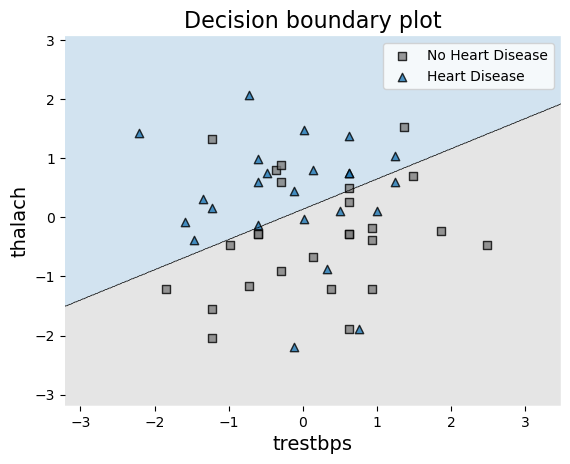

In [131]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    contourf_kwargs = {'alpha': 0.2}
    
    p = plot_decision_regions(X.to_numpy(), np.ravel(y).astype(int),
                              clf=logistic_model, contourf_kwargs=contourf_kwargs,
                              colors='#7f7f7f,#1f77b4')
    
    p.set_title('Decision boundary plot', fontsize=16)
    p.set_xlabel('trestbps', fontsize=14)
    p.set_ylabel('thalach', fontsize=14)
    
    L = plt.legend()
    L.get_texts()[0].set_text('No Heart Disease')
    L.get_texts()[1].set_text('Heart Disease')

In [133]:
accuracy = logistic_model.score(X, y)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.7400


In [136]:
input_data = pd.DataFrame([{
    'age': 0,
    'trestbps': 130,
    'chol': 0,
    'thalach': 170
}])

scaled_input = scaler.transform(input_data)
scaled_df = pd.DataFrame(scaled_input, columns=input_data.columns)

X_input = scaled_df[['trestbps', 'thalach']]

pred_class = logistic_model.predict(X_input)
pred_proba = logistic_model.predict_proba(X_input)

print("Predicted class:", "Heart Disease" if pred_class[0] == 1 else "No Heart Disease")
print("Probabilities:", pred_proba[0])

Predicted class: Heart Disease
Probabilities: [0.35983988 0.64016012]
